In [1]:
%load_ext autoreload
%autoreload 2

In [190]:
%env CHRONOSTRAIN_INI=/home/youn/work/chronostrain/examples/umb/files/chronostrain.ini
%env CHRONOSTRAIN_DB_JSON=/mnt/e/ecoli_db/chronostrain_files/ecoli.json
%env CHRONOSTRAIN_DB_DIR=/mnt/e/ecoli_db/chronostrain_files
%env CHRONOSTRAIN_CACHE_DIR=./cache
%env CHRONOSTRAIN_LOG_INI=./logging.ini
%env JAX_PLATFORM_NAME=cpu


from typing import *
from pathlib import Path
import numpy as np
import jax
import pandas as pd

from chronostrain.config import cfg
from chronostrain.database import *
from chronostrain.inference import *

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as patches
import matplotlib.transforms as mtransforms
from matplotlib import gridspec
import string
import seaborn as sb

from Bio import Phylo
from helpers import *

env: CHRONOSTRAIN_INI=/home/youn/work/chronostrain/examples/umb/files/chronostrain.ini
env: CHRONOSTRAIN_DB_JSON=/mnt/e/ecoli_db/chronostrain_files/ecoli.json
env: CHRONOSTRAIN_DB_DIR=/mnt/e/ecoli_db/chronostrain_files
env: CHRONOSTRAIN_CACHE_DIR=./cache
env: CHRONOSTRAIN_LOG_INI=./logging.ini
env: JAX_PLATFORM_NAME=cpu


In [3]:
# Ensure that basic bash commands work.

try:
    VARS_SET
except NameError:
    VARS_SET = True
    _cwd = %pwd
    _parent_cwd = Path(_cwd).parent
    _start_path = %env PATH
    %env PATH=$_start_path:/usr/bin


# zcat is needed by bowtie2
!zcat --version  # if this doesn't work, then install "gzip" (e.g. conda install -c conda-forge gzip)

env: PATH=/home/youn/mambaforge/envs/chronostrain/bin:/usr/bin
zcat (gzip) 1.12
Copyright (C) 2007, 2011-2018 Free Software Foundation, Inc.
This is free software.  You may redistribute copies of it under the terms of
the GNU General Public License <https://www.gnu.org/licenses/gpl.html>.
There is NO WARRANTY, to the extent permitted by law.

Written by Paul Eggert.


# Phylogroup-based labelling/coloring

In [4]:
def annotate_phylogroups(db: StrainDatabase, phylogroup_path: Path):
    """To each strain, add a phylogroup annotation."""
    for strain in db.all_strains():
        strain.phylogroup = '?'
    
    with open(phylogroup_path, 'r') as f:
        for line in f:
            tokens = line.strip().split('\t')
            accession = Path(tokens[0]).with_suffix('').with_suffix('').name
            phylogroup = tokens[4]
            try:
                db.get_strain(accession).phylogroup = phylogroup
            except QueryNotFoundError:
                pass
    

def create_palette(db: StrainDatabase):
    palette_tab20 = sb.color_palette("tab20", 20)
    phylogroup_colors = {
        'A': palette_tab20[4],
        'B1': palette_tab20[1],
        'B2': palette_tab20[6],
        'C': palette_tab20[0],
        'D': 'gold',
        'E': palette_tab20[8],
        'F': palette_tab20[7],
        'G': palette_tab20[5],
        'fergusonii': palette_tab20[2],
        'albertii': palette_tab20[3],
        'E or cladeI': palette_tab20[9],
        'cladeI': palette_tab20[10],
        'Unknown': palette_tab20[11],
        'cladeV': palette_tab20[12],
        '?': np.array([0.0, 0.0, 0.0, 1.0])
    }
    strain_colors = {
        s.id: phylogroup_colors[s.phylogroup]
        for s in db.all_strains()
    }
    return phylogroup_colors, strain_colors

In [5]:
db = cfg.database_cfg.get_database()
annotate_phylogroups(db, phylogroup_path=Path("/mnt/e/ecoli_db/phylogeny/ClermonTyping/umb_phylogroups_complete.txt"))
clades = [
    "A", "B1", "B2", "C", "D", "E", "F", "G", 
    "fergusonii", "albertii", "E or cladeI", "cladeI", "Unknown", "cladeV",
    "N/A"
]
phylo_colors, strain_colors = create_palette(db)

abx_acronym = {'nitrofuran': 'N', 'fluoroquinolone': 'F', 'beta_lactam': 'B', 'sulfonamide': 'S', 'macrolide': 'M', 'tetracycline': 'T'}
abx_colors = {'nitrofuran': 'red', 'fluoroquinolone': 'magenta', 'beta_lactam': 'green', 'sulfonamide': 'blue', 'macrolide': 'cyan', 'tetracycline': 'orange'}
abx_labels = {'nitrofuran': 'Nitrofurantoin', 'fluoroquinolone': 'Fluoroquinolone', 'beta_lactam': 'Beta Lactam', 'sulfonamide': 'Sulfonamide', 'macrolide': 'Macrolide', 'tetracycline': 'Tetracycline'}

# StrainGST stuff

In [6]:
# ======================================= Parsing
umb_entries = parse_umb_entries(
    straingst_output_basedir=Path("/mnt/e/strainge/straingst_umb"),
    entries_csv_path=Path("/home/youn/work/chronostrain/examples/umb/files/umb_samples.csv")
)
umb_dates_df = retrieve_patient_dates(umb_entries)
straingst_df = straingst_dataframe(
    umb_entries,
    Path("/mnt/e/chronostrain/phylogeny/ClermonTyping/umb_phylogroups_complete.txt")
)

# Plot helper

In [187]:
def add_figure_labels(fig, axes):
    """ add A/B/C/D labels """
    for n, _ax in enumerate(axes):
        # _ax.text(-.1, 1.1, string.ascii_uppercase[n], transform=_ax.transAxes, size=20, weight='bold')
        trans = mtransforms.ScaledTranslation(-25/72, -3/72, fig.dpi_scale_trans)
        _ax.text(0, 1, string.ascii_lowercase[n], transform=_ax.transAxes + trans,
                 va='bottom', fontfamily='sans-serif', weight='bold', size=15)

# Function for plotting UMB

In [283]:
base_dir = Path("/data/cctm/youn/umb")
bf_threshold = 100000.0
prior_p = 0.001

# What is the probability threshold?
_x = bf_threshold * (prior_p / (1 - prior_p))
p_threshold = _x / (_x + 1)
print("BF threshold = {} // p threhsold = {}".format(bf_threshold, p_threshold))


metadata_df = pd.read_csv(Path("/home/youn/work/chronostrain/examples/umb/files/umb_samples.csv"))


# ====== Load results
res_cache = {}

def load_result(umb_id):
    if umb_id in res_cache:
        return
    res = {}
    try:
        res['stool'] = ChronostrainResult(
            umb_id,
            db, 
            GaussianStrainCorrelatedWithGlobalZerosPosterior,
            base_dir / 'stool' / umb_id / 'chronostrain', 
            base_dir / 'stool' / umb_id / 'filtered' / 'filtered_reads.csv',
            target_bayes_factor=bf_threshold
        )
    except FileNotFoundError as e:
        print(f"File error while loading stool: {str(e)}")
        res['stool'] = None

    try:
        res['urine'] = ChronostrainResult(
            umb_id,
            db, 
            GaussianStrainCorrelatedWithGlobalZerosPosterior,
            base_dir / 'urine' / umb_id / 'chronostrain', 
            base_dir / 'urine' / umb_id / 'filtered' / 'filtered_reads.csv',
            target_bayes_factor=bf_threshold
        )
    except FileNotFoundError as e:
        print(f"File error while loading urine: {str(e)}")
        res['urine'] = None

    plate_res = []
    umb_number = umb_id[3:]
    plate_prefix = "Esch_coli_UMB_{}_".format(umb_number)
    for f in (base_dir / 'plate_scrapes').glob(f'{plate_prefix}*'):
        sample_str = f.name[len(plate_prefix):]
        timepoint_id = sample_str.split("_")[0]
        print("Found plate {} -> timepoint_id {}".format(f.name, timepoint_id))
        row = metadata_df.loc[metadata_df['SampleName'] == f'{umb_id}_{timepoint_id}', 'days']
        plate_t = row.item()
        try:
            plate_res.append(
                (
                    plate_t, ChronostrainResult(
                        umb_id,
                        db, 
                        GaussianStrainCorrelatedWithGlobalZerosPosterior,
                        f / 'chronostrain', 
                        f / 'filtered' / 'filtered_reads.csv',
                        target_bayes_factor=bf_threshold
                    )
                )
            )
        except FileNotFoundError as e:
            print(f"File error while loading plate: {f.name}")
    res['plate'] = plate_res
    res_cache[umb_id] = res

BF threshold = 100000.0 // p threhsold = 0.9901088129585441


In [267]:
def load_abx_df(umb_id) -> pd.DataFrame:
    abx_df = pd.read_csv(Path().resolve().parent / 'files' / 'abx_table.tsv', sep="\t").astype(
        dtype={
            'experiment_day_ended': 'int64',
            'date_ended': 'datetime64[ns]'
        }
    )
    umb_df = pd.read_csv(Path(Path().resolve().parent / 'files' / 'umb_samples.csv'))
    umb_dates = umb_df.groupby('ID').head(1)[['ID', 'date', 'days']].astype({'date': 'datetime64[ns]'})
    umb_dates.columns = ['ID', 'ref_date', 'ref_days']

    abx_df = abx_df.merge(umb_dates, left_on='patient_id', right_on='ID')
    abx_df['experiment_day_ended'] = (abx_df['date_ended'] - abx_df['ref_date']).dt.days + abx_df['ref_days']
    abx_df = abx_df[['patient_id', 'raw_abx', 'clean_abx', 'abx_class', 'date', 'days_before', 'weeks_before', 'date_ended', 'experiment_day_ended']]
    return abx_df.loc[abx_df['patient_id'] == umb_id]


def load_uti_df(umb_id) -> pd.DataFrame:
    uti_df = pd.read_csv(Path().resolve().parent / 'files' / 'utis.csv').astype({'UTIDate': 'datetime64[ns]'})
    uti_df = uti_df.loc[uti_df['Patient'] == umb_id]
    
    umb_df = pd.read_csv(Path(Path().resolve().parent / 'files' / 'umb_samples.csv'))
    umb_dates = umb_df.groupby('ID').head(1)[['ID', 'date', 'days']].astype({'date': 'datetime64[ns]'})
    umb_dates.columns = ['ID', 'ref_date', 'ref_days']
    
    uti_df = uti_df.merge(umb_dates, left_on='Patient', right_on='ID')
    uti_df['UTIDay'] = (uti_df['UTIDate'] - uti_df['ref_date']).dt.days + uti_df['ref_days']
    uti_df = uti_df[['Patient', 'UTIDate', 'UTIDay']]
    
    return uti_df


def load_sample_df(umb_id) -> pd.DataFrame:
    df = pd.read_csv(Path().resolve().parent / 'files' / "umb_samples.csv", sep=',').astype({
        'date': 'datetime64[ns]'
    })
    df['T'] = df['days']
    return df.loc[df['ID'] == umb_id, ['Run', 'ID', 'SampleName', 'date', 'Group', 'type', 'T']]

In [270]:
def plot_umb(umb_id: str, base_dir: Path, seed: int, result_cache: Dict[str, Dict[str, ChronostrainResult]], abund_lb: float, width: float, include_straingst: bool):
    cfg.engine_cfg.prng_key = jax.random.PRNGKey(seed)  # for reproducibility
    res = result_cache[umb_id]
    stool_result = res['stool']
    urine_result = res.get('urine', None)
    plate_results = res.get('plate', [])
        
        
    plotter = ChronostrainRenderer(
        abund_lb=abund_lb, 
        target_taxon=Taxon("Escherichia", "coli"), 
        strain_palette=strain_colors,
        stool_result=stool_result,
        urine_result=urine_result,
        plate_results=plate_results,
        abx_df=load_abx_df(umb_id),
        abx_palette=abx_colors,
        abx_label=abx_acronym,
        uti_df=load_uti_df(umb_id),
        sample_df=load_sample_df(umb_id)
    )
    
    sb.set_style("whitegrid")

    if not include_straingst:
        scatterplot_n_taxa = len(pd.unique(plotter.get_merged_df()['StrainId']))
        scatterplot_ht_scale = scatterplot_n_taxa / 8
        fig = plt.figure(constrained_layout=True, figsize=(width, 2.0 * (1.2 + scatterplot_ht_scale) + 5.0))
        gs = gridspec.GridSpec(ncols=2, nrows=3, figure=fig, height_ratios=[0.7, scatterplot_ht_scale, 1], width_ratios=[1, 2])
    else:
        scatterplot_n_taxa_chronostrain = len(pd.unique(plotter.get_merged_df()['StrainId']))
        scatterplot_ht_scale_chronostrain = scatterplot_n_taxa_chronostrain / 8

        straingst_res_umb = straingst_df.loc[straingst_df['Patient'] == umb_id]
        scatterplot_n_taxa_straingst = len(pd.unique(straingst_res_umb['StrainId']))
        scatterplot_ht_scale_straingst = scatterplot_n_taxa_straingst / 8
        
        fig = plt.figure(constrained_layout=True, figsize=(width, 2.0 * (1.2 + scatterplot_ht_scale_chronostrain + scatterplot_ht_scale_straingst) + 5.0))
        gs = gridspec.GridSpec(ncols=2, nrows=5, figure=fig, height_ratios=[0.7, scatterplot_ht_scale_chronostrain, 1, scatterplot_ht_scale_straingst, 1], width_ratios=[1, 2])
        

    # ====================== legend axis
    legend_ax = fig.add_subplot(gs[0, :])
    
    # ====================== Phylogroup legend
    legends = []
    handles, labels = zip(*[
        (legend_ax.scatter([], [], facecolors=phylo_colors[p]), p) 
        for p in ['A', 'B1', 'B2', 'C', 'D', 'E', 'F', 'G', 'E or cladeI', 'cladeI', 'cladeV', 'Unknown']
    ])
    phylogroup_legend = plt.legend(handles, labels, title="Phylogroup", bbox_to_anchor=(0.15, 0.5), loc="center left", ncol=6)
    legends.append(phylogroup_legend)

    # ====================== ABX Legend
    def create_text_legend_proxy(label, color):
        """
        Hack to use Letter-based markers for legend creation
        """
        t = matplotlib.textpath.TextPath(xy=(0, -.2), s=label, size=0.5)
        line = matplotlib.lines.Line2D(
            [0], [-1], linestyle='none',
            marker=t, markeredgecolor=color, markerfacecolor=color, markersize=20.0, markeredgewidth=0.1,
        )
        return line
    
    _abx = set(pd.unique(plotter.abx_df['abx_class']))
    abx_lbls = [
        (
            create_text_legend_proxy(abx_acronym[abx_name], abx_colors[abx_name]),
            abx_label
        )
        for abx_name, abx_label in abx_labels.items()
        if abx_name in _abx
    ]
    if len(abx_lbls) > 0:
        handles, labels = zip(*abx_lbls)
        abx_legend = plt.legend(handles, labels, title="Antibiotics", bbox_to_anchor=(0.75, 0.5), loc="center left", ncol=3)
        legends.append(abx_legend)

    # ======================= Render legends
    legend_ax.axis('off')
    for legend in legends:
        legend_ax.add_artist(legend)

    fig_axes = []
    # ===================== Tree
    marker_tree = Phylo.read(str("/mnt/e/ecoli_db/phylogeny/tree/tree.nwk"), "newick")
    marker_tree.ladderize()
    tree_ax = fig.add_subplot(gs[1, 0])
    x_posns, y_posns = plotter.plot_tree(
        ax=tree_ax,
        tree=marker_tree
    )
    tree_ax.set_title("Marker distance")
    fig_axes.append(tree_ax)

    
    timeseries_axes = []
    # ===================== Clade marker scatterplots
    marker_sz = 0.5 # scatterplot marker size
    scatter_ax = fig.add_subplot(gs[1, 1])
    timeseries_axes.append(scatter_ax)
    # pre-compute ordering.
    y_ordering = [(clade.name, y_pos) for clade, y_pos in y_posns.items() if clade.is_terminal()]
    y_ordering = sorted(y_ordering, key=lambda p: p[1])
    y_ordering = {
        acc: len(y_ordering) - y_idx
        for y_idx, (acc, y_pos) in enumerate(y_ordering)
    }
    plotter.plot_clade_presence(
        scatter_ax, strain_y=y_ordering
    )
    fig_axes.append(scatter_ax)
    
    # ===================== Relative Abundance lineplot
    abund_ax = fig.add_subplot(gs[2, 1])
    timeseries_axes.append(abund_ax)
    ymin, ymax = plotter.plot_overall_relabund(abund_ax, mode='stool')
    abund_ax.set_ylim(bottom=max(ymin, 1e-7), top=min(ymax*10, 1.0))
    scatter_ax.sharex(abund_ax)
    fig_axes.append(abund_ax)

    if include_straingst:
        tree_ax2 = fig.add_subplot(gs[3, 0])
        mash_tree = Phylo.read(str("/mnt/e/ecoli_db/phylogeny/tree/mash_tree.nwk"), "newick")
        mash_tree.ladderize()
        _, straingst_y_posns = plot_tree(straingst_res_umb, phylo_colors, tree_ax2, mash_tree)
        tree_ax2.set_title("Whole-genome distance")
        straingst_y_ordering = [(clade.name, y_pos) for clade, y_pos in straingst_y_posns.items() if clade.is_terminal()]
        straingst_y_ordering = sorted(straingst_y_ordering, key=lambda p: p[1])
        straingst_y_ordering = {
            acc: len(straingst_y_ordering) - y_idx
            for y_idx, (acc, y_pos) in enumerate(straingst_y_ordering)
        }

        clade_ax2 = fig.add_subplot(gs[3, 1])
        plot_clade_presence(
            straingst_res_umb, 
            umb_dates_df.loc[umb_dates_df['Patient'] == umb_id],
            phylo_colors,
            clade_ax2,
            strain_y=straingst_y_ordering,
            show_ylabels=True
        )
        clade_ax2.sharex(abund_ax)
        timeseries_axes.append(clade_ax2)
        
        abund_ax2 = fig.add_subplot(gs[4, 1])
        plot_straingst_abundances(
            straingst_res_umb, 
            umb_dates_df.loc[umb_dates_df['Patient'] == umb_id],
            phylo_colors,  abund_ax2, mode='stool', yscale='log'
        )
        abund_ax2.sharey(abund_ax)
        abund_ax2.sharex(abund_ax)
        timeseries_axes.append(abund_ax2)
        fig_axes += [tree_ax2, clade_ax2, abund_ax2]

    # ================== ABX
    for ax in timeseries_axes:
        plotter.plot_abx(ax, draw_labels=True)

    # ================== Infections
    for ax in timeseries_axes:
        plotter.plot_infections(ax)

    # ================== Xtick transform integers to dates.
    plotter.set_xtick_dates(timeseries_axes[-1], show_t=False)
    for ax in timeseries_axes[:-1]:
        ax.tick_params(labelbottom=False)

    # add figure labels
    add_figure_labels(
        fig, fig_axes
    )

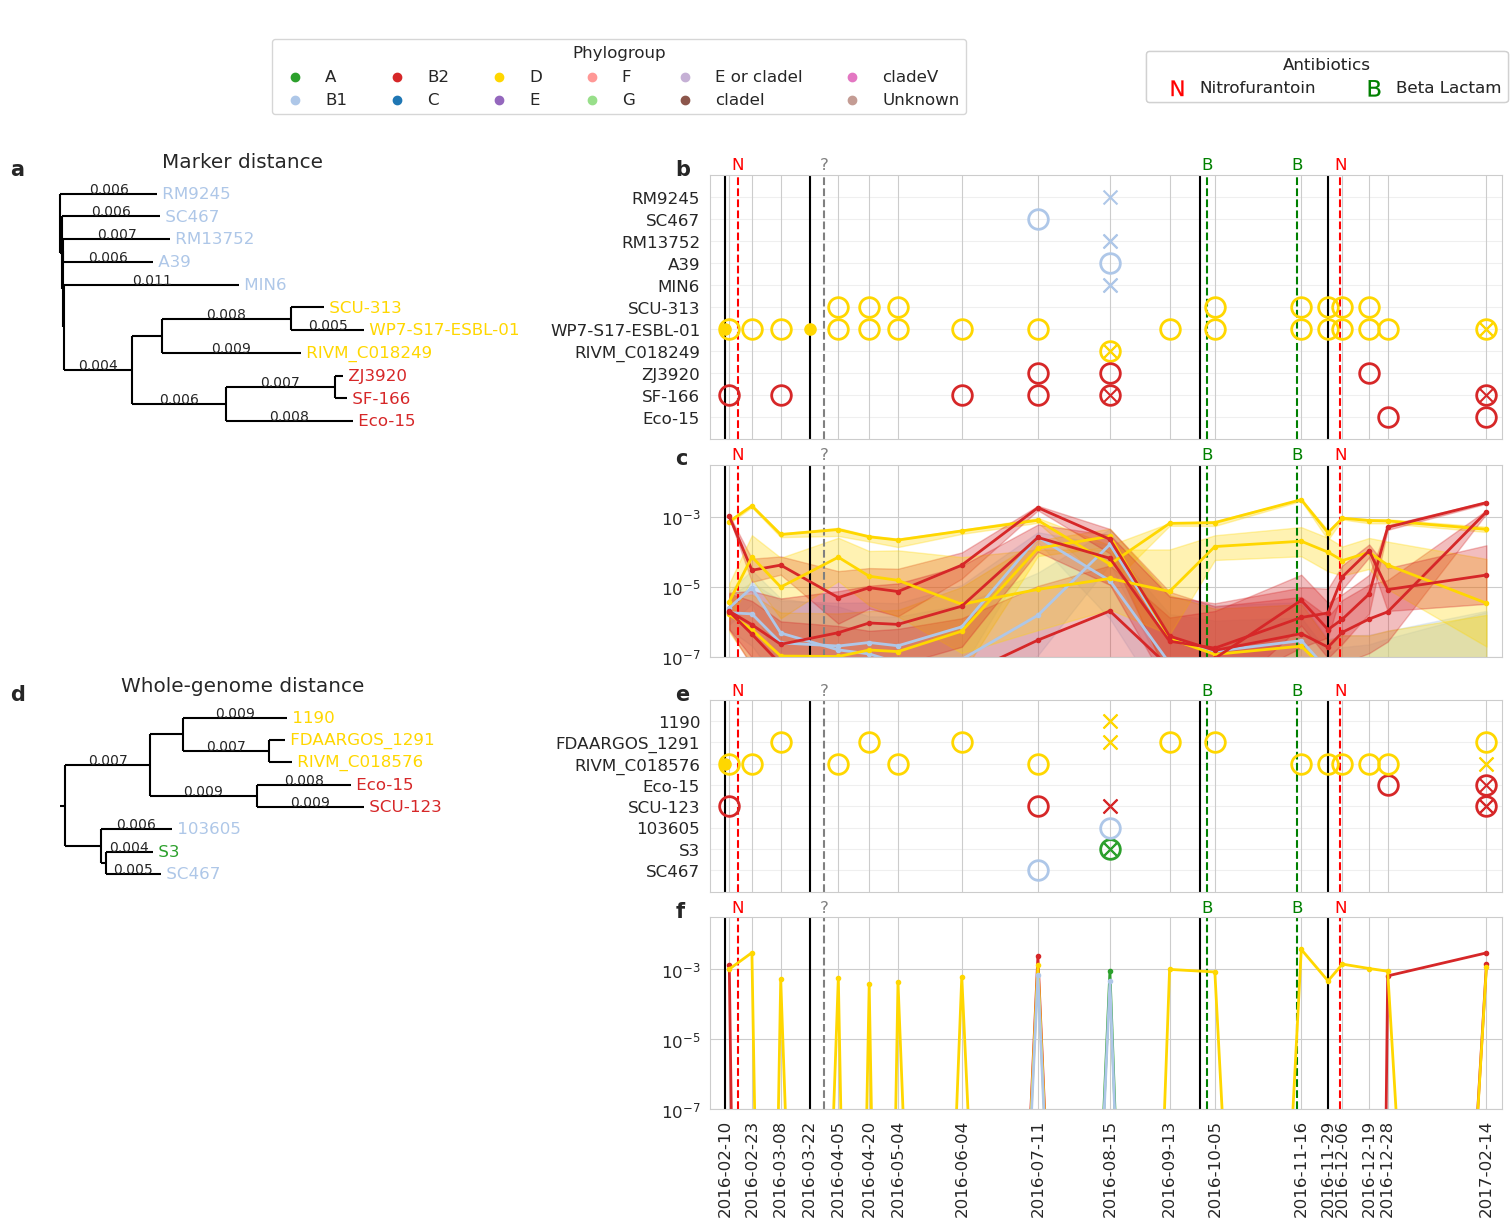

In [281]:
umb_id = 'UMB18'
plt.rcParams.update({'font.size': 12})
load_result(umb_id)
plot_umb(
    umb_id, base_dir, seed=31415, result_cache=res_cache, width=15.0, abund_lb=0.05,
    include_straingst=True
)

plot_dir = Path() / 'plots'
plot_dir.mkdir(exist_ok=True)
plt.savefig(plot_dir / f'{umb_id}_both_methods.svg')

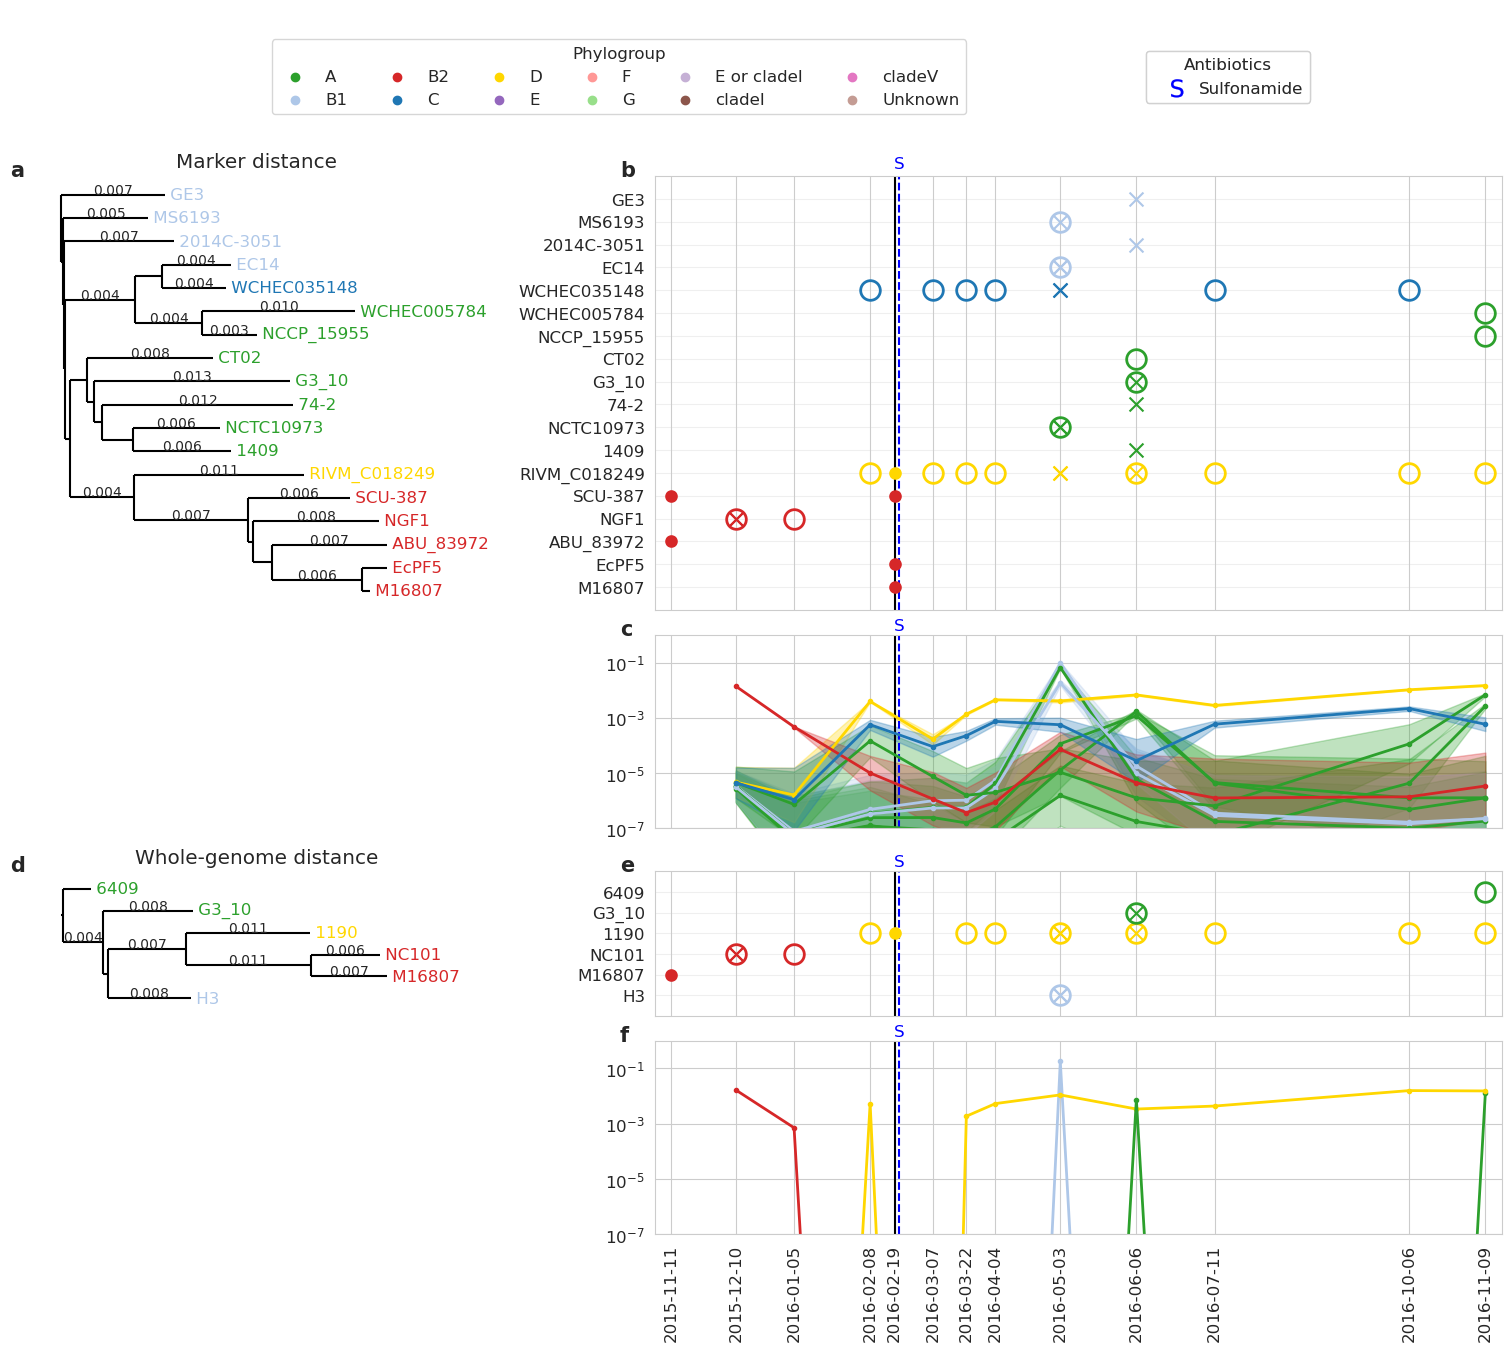

In [274]:
umb_id = 'UMB11'
plt.rcParams.update({'font.size': 12})
load_result(umb_id)
plot_umb(
    umb_id, base_dir, seed=31415, result_cache=res_cache, width=15.0, abund_lb=0.05,
    include_straingst=True
)

# plot_dir = Path() / 'plots'
# plot_dir.mkdir(exist_ok=True)
# plt.savefig(plot_dir / f'{umb_id}.svg')

In [13]:
x = []
for s in db.all_strains():
    if not s.metadata.species == 'coli':
        continue
    marker_len = sum(len(m) for m in s.markers)
    ratio = marker_len / s.metadata.total_len
    x.append(ratio)
np.mean(x)

0.02435537173614547

# Whole-dataset plot

In [284]:
umb_ids = ['UMB{}'.format(str(x).zfill(2)) for x in range(1, 32)]


for umb_id in umb_ids:
    print(f"loading {umb_id}")
    load_result(umb_id)
umb_results = list(x['stool'] for x in res_cache.values())
umb_results = [res for res in umb_results if res is not None]

loading UMB01
9 of 1794 inference strains passed BF Threshold > 100000.0
1 of 776 inference strains passed BF Threshold > 100000.0
Found plate Esch_coli_UMB_01_01_2 -> timepoint_id 01
45 of 1021 inference strains passed BF Threshold > 100000.0
Found plate Esch_coli_UMB_01_01 -> timepoint_id 01
55 of 881 inference strains passed BF Threshold > 100000.0
Found plate Esch_coli_UMB_01_03_2 -> timepoint_id 03
36 of 1015 inference strains passed BF Threshold > 100000.0
Found plate Esch_coli_UMB_01_03 -> timepoint_id 03
44 of 913 inference strains passed BF Threshold > 100000.0
loading UMB02
13 of 1235 inference strains passed BF Threshold > 100000.0
1 of 734 inference strains passed BF Threshold > 100000.0
loading UMB03
47 of 1576 inference strains passed BF Threshold > 100000.0
16 of 1594 inference strains passed BF Threshold > 100000.0
loading UMB04
11 of 1498 inference strains passed BF Threshold > 100000.0
File error while loading urine: [Errno 2] No such file or directory: '/data/cctm/yo

/home/youn/mambaforge/envs/chronostrain/lib/python3.10/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


loading UMB11
34 of 2077 inference strains passed BF Threshold > 100000.0
4 of 873 inference strains passed BF Threshold > 100000.0
Found plate Esch_coli_UMB_11_01_2 -> timepoint_id 01
53 of 1234 inference strains passed BF Threshold > 100000.0
Found plate Esch_coli_UMB_11_01 -> timepoint_id 01
58 of 1240 inference strains passed BF Threshold > 100000.0
Found plate Esch_coli_UMB_11_06_2 -> timepoint_id 06
5 of 889 inference strains passed BF Threshold > 100000.0
Found plate Esch_coli_UMB_11_06 -> timepoint_id 06
14 of 886 inference strains passed BF Threshold > 100000.0
Found plate Esch_coli_UMB_11_07 -> timepoint_id 07
57 of 1013 inference strains passed BF Threshold > 100000.0
loading UMB12
10 of 1759 inference strains passed BF Threshold > 100000.0
2 of 881 inference strains passed BF Threshold > 100000.0
Found plate Esch_coli_UMB_12_08 -> timepoint_id 08
32 of 862 inference strains passed BF Threshold > 100000.0
loading UMB13
23 of 1894 inference strains passed BF Threshold > 10000

/home/youn/mambaforge/envs/chronostrain/lib/python3.10/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


Found plate Esch_coli_UMB_24_06 -> timepoint_id 06
File error while loading plate: Esch_coli_UMB_24_06
Found plate Esch_coli_UMB_24_08_2 -> timepoint_id 08
File error while loading plate: Esch_coli_UMB_24_08_2
Found plate Esch_coli_UMB_24_08 -> timepoint_id 08
File error while loading plate: Esch_coli_UMB_24_08
Found plate Esch_coli_UMB_24_03_2 -> timepoint_id 03
File error while loading plate: Esch_coli_UMB_24_03_2
Found plate Esch_coli_UMB_24_03 -> timepoint_id 03
File error while loading plate: Esch_coli_UMB_24_03
loading UMB25
17 of 1633 inference strains passed BF Threshold > 100000.0
0 of 2 inference strains passed BF Threshold > 100000.0


/home/youn/mambaforge/envs/chronostrain/lib/python3.10/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


loading UMB26
36 of 2173 inference strains passed BF Threshold > 100000.0
0 of 7 inference strains passed BF Threshold > 100000.0
loading UMB27


/home/youn/mambaforge/envs/chronostrain/lib/python3.10/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


17 of 1627 inference strains passed BF Threshold > 100000.0
File error while loading urine: [Errno 2] No such file or directory: '/data/cctm/youn/umb/urine/UMB27/chronostrain/adhoc_cluster.txt'
loading UMB28
54 of 1748 inference strains passed BF Threshold > 100000.0
0 of 37 inference strains passed BF Threshold > 100000.0
loading UMB29


/home/youn/mambaforge/envs/chronostrain/lib/python3.10/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


19 of 1112 inference strains passed BF Threshold > 100000.0
0 of 2 inference strains passed BF Threshold > 100000.0


/home/youn/mambaforge/envs/chronostrain/lib/python3.10/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


loading UMB30
1 of 252 inference strains passed BF Threshold > 100000.0
0 of 29 inference strains passed BF Threshold > 100000.0


/home/youn/mambaforge/envs/chronostrain/lib/python3.10/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


loading UMB31
39 of 1749 inference strains passed BF Threshold > 100000.0
0 of 5 inference strains passed BF Threshold > 100000.0


/home/youn/mambaforge/envs/chronostrain/lib/python3.10/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


In [285]:
chronostrain_corr_df = analyze_chronostrain(
    umb_results,
    Path("/mnt/e/ecoli_db/phylogeny/ClermonTyping/umb_phylogroups_complete.txt"),
    0.05
)

Computing correlations for UMB01
Computing correlations for UMB02
Computing correlations for UMB03
Computing correlations for UMB04
Computing correlations for UMB05
Computing correlations for UMB06
Computing correlations for UMB07
Computing correlations for UMB08
Computing correlations for UMB09
Computing correlations for UMB10
Computing correlations for UMB11
Computing correlations for UMB12
Computing correlations for UMB13
Computing correlations for UMB14
Computing correlations for UMB15
Computing correlations for UMB16
Computing correlations for UMB17
Computing correlations for UMB18
Computing correlations for UMB19
Computing correlations for UMB20
Computing correlations for UMB21
Computing correlations for UMB22
Computing correlations for UMB23
Computing correlations for UMB24
Computing correlations for UMB25
Computing correlations for UMB26
Computing correlations for UMB27
Computing correlations for UMB28
Computing correlations for UMB29
Computing correlations for UMB30
Computing 

In [235]:
strainge_corr_df = analyze_strainge(
    straingst_df,
    pd.read_csv(Path().resolve().parent / 'files' / 'umb_samples.csv'),
    Path("/mnt/e/ecoli_db/phylogeny/ClermonTyping/umb_phylogroups_complete.txt")
)
display(strainge_corr_df)

,Patient,Phylogroup,Coherence,Abundance
0,UMB01,A,NaN,NaN
1,UMB01,cladeV,NaN,NaN
2,UMB01,E,NaN,NaN
3,UMB01,Unknown,NaN,NaN
4,UMB01,E or cladeI,NaN,NaN
...,...,...,...,...
415,UMB31,G,NaN,NaN
416,UMB31,F,NaN,NaN
417,UMB31,fergusonii,NaN,NaN
418,UMB31,D,NaN,NaN


/home/youn/mambaforge/envs/chronostrain/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


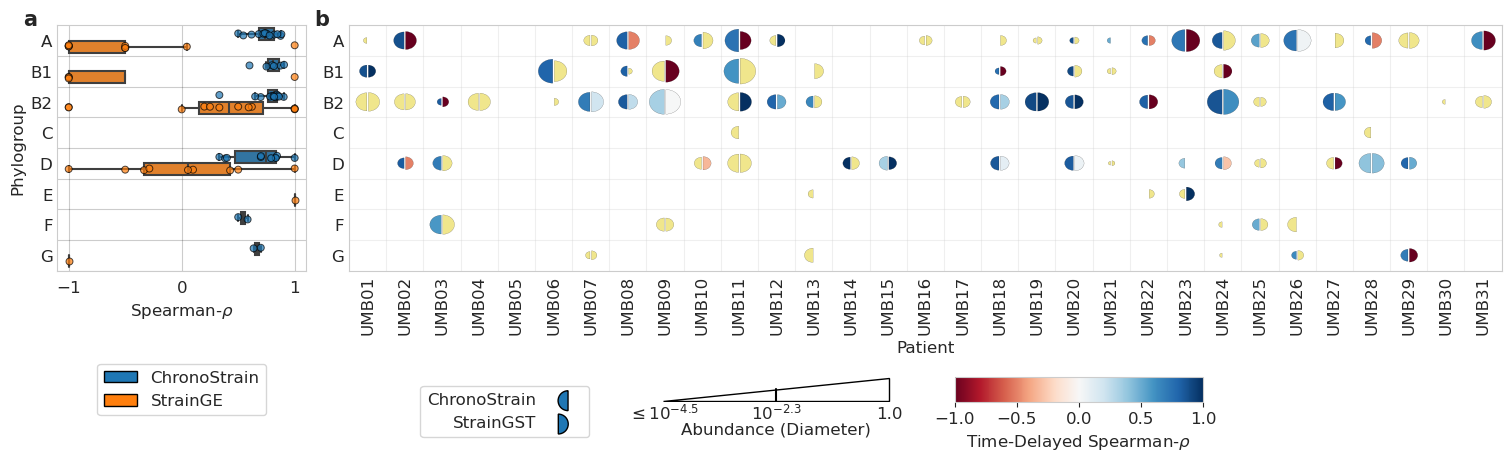

In [343]:
def half_circle(center, radius, color, angle=0, label=''):
    """
    Add two half circles to the axes *ax* (or the current axes) with the 
    specified facecolors *colors* rotated at *angle* (in degrees).
    """
    theta1, theta2 = angle, angle + 180
    w = matplotlib.patches.Wedge(center, radius, theta1, theta2, fc=color, edgecolor='black', linewidth=0.1, label=label)
    return w


def scatter_heatmap(
    df: pd.DataFrame, 
    ax, 
    row_name:str, 
    column_name: str, 
    color_name: str, 
    size_name: str, 
    circle_direction: str, 
    size_max: float, 
    size_min: float,
    colormap, norm,
    rows: List[str]=None, 
    columns: List[str]=None,
    nan_color='black'
):
    if rows is None:
        # Reverse row ordering
        pivot_df = df.pivot(index=row_name, columns=column_name, values=color_name)  # create only for initialization.
        ylabels = pivot_df.index.values.tolist()[::-1]
        del pivot_df
    else:
        ylabels = rows[::-1]

    if columns is None:
        # Reverse col ordering
        pivot_df = df.pivot(index=row_name, columns=column_name, values=color_name)  # create only for initialization.
        xlabels = pivot_df.columns.values.tolist()
        del pivot_df
    else:
        xlabels = columns

    n_rows = len(ylabels)
    n_cols = len(xlabels)
    x, y = np.meshgrid(np.arange(n_cols), np.arange(n_rows-1, -1, -1))

    def create_pivot(_value_name: str):
        pivoted = df.pivot(index=row_name, columns=column_name, values=_value_name)
        if rows is not None:
            for r in rows:
                if not (r in pivoted.index):
                    pivoted.loc[r] = np.nan
            row_index = {r: i for i, r in enumerate(rows)}
            pivoted = pivoted.sort_index(key=lambda r: r.map(row_index))

        if columns is not None:
            for c in columns:
                if not (c in pivoted.columns):
                    pivoted[c] = np.nan
            pivoted = pivoted[columns]
        return pivoted

    sizes = create_pivot(size_name)
    # display(sizes)
    sizes = np.log10(sizes)
    sizes = sizes.to_numpy()

    # linear re-scaling (place in [0, 1] interval)
    # sizes = sizes - size_offset
    # sizes = sizes / np.max(sizes)
    diameters = (sizes - size_min) / (size_max - size_min)
    diameters[np.isnan(diameters)] = 0.
    radii = diameters / 2

    colors = create_pivot(color_name)
    # display(colors)
    # colors = colors.fillna(0).to_numpy()
    colors = colors.to_numpy()
    if np.max(sizes) > 1.0:
        raise Exception(f"size value in column `{size_name}` of dataframe exceeded 1.0: {np.max(sizes)}")

    """ Full scatterplot. """
    # circles = [plt.Circle((_x, _y), radius=_r) for _r, _x, _y in zip(radii.flat, x.flat, y.flat)]
    # col = PatchCollection(circles, array=colors.flatten(), cmap=cmap, norm=matplotlib.colors.Normalize(vmin=0, vmax=1), edgecolor='black', linewidth=0.5)
    # ax.add_collection(col)

    """ Semicircle scatterplot. """
    if circle_direction == "left":
        angle = 90
        xoffset = -0.02
    else:
        angle = 270
        xoffset = 0.02

    circles = []

    for _r, _x, _y, _c in zip(radii.flat, x.flat, y.flat, colors.flat):
        if not np.isnan(_r) and _r > 0:
            if np.isnan(_c):
                circ = half_circle((_x + xoffset, _y), radius=_r, color=nan_color, angle=angle)
            else:
                circ = half_circle((_x + xoffset, _y), radius=_r, color=colormap(norm(_c)), angle=angle)
            circles.append(circ)
    for c in circles:
        ax.add_artist(c)

    """ Draw the rest of the labels. """
    ax.set(xticks=np.arange(n_cols), 
           yticks=np.arange(n_rows),
           xticklabels=xlabels, 
           yticklabels=ylabels)
    ax.set_xticklabels(xlabels, rotation=90, horizontalalignment='center', verticalalignment='top')
    ax.set_xticks(np.arange(n_cols + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(n_rows + 1) - 0.5, minor=True)
    ax.grid(False)
    ax.grid(which='minor', alpha=0.3)
    ax.tick_params('both', length=0)
    ax.tick_params('both', which='minor', length=0)


def coherence_breakdown(
    fig, ax, phylogroups, chronostrain_corr_df, straingst_corr_df,
    circle_ax, diam_ax, cbar_ax,
    nan_color='black',
):
    # Calculate mutual minimum.
    # _x = np.log10(straingst_corr_df['Abundance'].to_numpy())
    # display(_x[~np.isnan(_x)])
    all_sizes = np.concatenate([
        chronostrain_corr_df['Abundance'].to_numpy(),
        straingst_corr_df['Abundance'].to_numpy()
    ])
    min_size = np.min(all_sizes[~np.isnan(all_sizes) & (all_sizes > 1e-5)])
    min_size = np.log10(min_size)

    # manual setting!
    # min_size = -5.0

    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    colormap = matplotlib.colormaps['RdBu']
    scatter_heatmap(
        df=chronostrain_corr_df,
        row_name='Phylogroup',
        rows=phylogroups,
        column_name='Patient',
        columns=["UMB{}".format(str(x).zfill(2)) for x in range(1, 32, 1)],
        color_name='Coherence',
        size_name='Abundance',
        circle_direction='left',
        ax=ax,
        colormap=colormap, norm=norm,
        size_max=0,
        size_min=min_size,
        nan_color=nan_color,
    )
    scatter_heatmap(
        df=straingst_corr_df,
        row_name='Phylogroup',
        rows=phylogroups,
        column_name='Patient',
        columns=["UMB{}".format(str(x).zfill(2)) for x in range(1, 32, 1)],
        color_name='Coherence',
        size_name='Abundance',
        circle_direction='right',
        ax=ax,
        colormap=colormap, norm=norm,
        size_max=0,
        size_min=min_size,
        nan_color=nan_color,
    )

    legend_elements = [
        half_circle((3.5, 1), 1.1, 'tab:blue', angle=90, label='ChronoStrain'),
        half_circle((-3.5, 1), 1.1, 'tab:blue', angle=270, label='StrainGST')
    ]

    class _LegendHandler(HandlerPatch):
        def create_artists(self, legend, orig_handle,
                           xdescent, ydescent, width, height, fontsize, trans):
            x, y = orig_handle.center
            p = matplotlib.patches.Wedge(center=(10 + x, 1.5 + y), r=6.5 * orig_handle.r, theta1=orig_handle.theta1, theta2=orig_handle.theta2)
            self.update_prop(p, orig_handle, legend)
            p.set(linewidth=1.0)
            p.set_transform(trans)
            return [p]

    ax.set_ylabel("Phylogroup")
    ax.set_xlabel("Patient")

    # circle_ax = fig.add_axes([0.6, -0.005, 0.18, 0.026])
    circle_ax.axis('off')
    circle_ax.legend(
        handles=legend_elements, 
        markerfirst=False,
        handler_map={matplotlib.patches.Wedge: _LegendHandler()}
    )

    # diam_ax = fig.add_axes([0.4, -0.005, 0.18, 0.026])
    x = [0.0,1.0,1.0,0.0]
    y = [0.0,0.0,1.0,0.0]
    diam_ax.add_patch(patches.Polygon(xy=list(zip(x,y)), edgecolor='black', facecolor='white', fill=True))
    diam_ax.plot([0.5, 0.5], [0.0, 0.5], color='black', marker=None)
    diam_ax.text(0, -0.8, "$\leq 10^{{{:.1f}}}$".format(min_size), {'ha': 'center'})
    diam_ax.text(0.5, -0.8, "$10^{{{:.1f}}}$".format(min_size / 2), {'ha': 'center'})
    diam_ax.text(1, -0.8, "1.0", {'ha': 'center'})
    diam_ax.text(0.5, -1.5, "Abundance (Diameter)", {'ha': 'center'})
    diam_ax.axis('off')


    # cbar_ax = fig.add_axes([0.15, -0.005, 0.2, 0.02])
    fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=colormap), 
        cax=cbar_ax, label=r"Time-Delayed Spearman-$\rho$", orientation="horizontal"
    )


fig = plt.figure(constrained_layout=True, figsize=(15, 4.5))
gs = gridspec.GridSpec(ncols=5, nrows=2, figure=fig, width_ratios=[1, 1, 1, 1, 1], height_ratios=[10, 1])

plt.rcParams.update({'font.size': 12})

phylogroups_to_show = ['A', 'B1', 'B2', 'C', 'D', 'E', 'F', 'G']
boxplot_ax = fig.add_subplot(gs[0, :1])
method_palette = {'ChronoStrain': 'tab:blue', 'StrainGE': 'tab:orange'}
sb.boxplot(
    pd.concat([
        chronostrain_corr_df.assign(Method='ChronoStrain'),
        strainge_corr_df.assign(Method='StrainGE'),
    ], ignore_index=True),
    hue='Method',
    palette=method_palette,
    y='Phylogroup',
    x='Coherence',
    ax=boxplot_ax,
    order=phylogroups_to_show,
    showfliers=False
)
sb.stripplot(
    pd.concat([
        chronostrain_corr_df.assign(Method='ChronoStrain'),
        strainge_corr_df.assign(Method='StrainGE'),
    ], ignore_index=True),
    hue='Method',
    palette=method_palette,
    y='Phylogroup',
    x='Coherence',
    dodge=True,
    ax=boxplot_ax,
    order=phylogroups_to_show,
    edgecolor='black',
    linewidth=0.7,
    alpha=0.7
)
boxplot_ax.minorticks_on()
boxplot_ax.tick_params('y', length=0)
boxplot_ax.tick_params('y', which='minor', length=0)
boxplot_ax.set_yticks(list(range(len(phylogroups_to_show))))
boxplot_ax.set_yticks(
    np.array(list(range(len(phylogroups_to_show)))) + 0.5,
    minor=True
)
boxplot_ax.grid(which='minor', axis='y', color='black', alpha=0.2)
boxplot_ax.get_legend().set_visible(False)
boxplot_ax.set_xlabel(r'Spearman-$\rho$')

boxplot_legend_ax = fig.add_subplot(gs[1, 0])
legend_elements = [
    patches.Patch(facecolor=color, edgecolor='black', label=method)
    for method, color in method_palette.items()
]
boxplot_legend_ax.legend(handles=legend_elements, loc='center')
boxplot_legend_ax.axis('off')

scatter_ax = fig.add_subplot(gs[0, 1:])
circle_ax = fig.add_subplot(gs[1, 1])
diam_ax = fig.add_subplot(gs[1, 2])
cbar_ax = fig.add_subplot(gs[1, 3])
coherence_breakdown(
    fig, scatter_ax,
    phylogroups_to_show,
    chronostrain_corr_df,
    strainge_corr_df,
    circle_ax, 
    diam_ax, 
    cbar_ax,
    nan_color='khaki'
)
scatter_ax.set_ylabel(None)

add_figure_labels(
    fig, [boxplot_ax, scatter_ax]
)


plot_dir = Path() / 'plots'
plot_dir.mkdir(exist_ok=True)
plt.savefig(plot_dir / 'umb_summary.svg')

# UMB18 macconkey abundance

,StrainIdx,T,FilterRelAbundLower,FilterRelAbundMedian,FilterRelAbundUpper,FilterRelAbundVar,OverallRelAbundLower,OverallRelAbundMedian,OverallRelAbundUpper,OverallRelAbundVar,LatentMean,LatentVar,StrainId,Genus,Species,StrainName,PosteriorProb
348,348,1000.0,0.074477,0.079477,0.084829,0.000007,0.066023,0.070549,0.075384,0.000006,0.079492,0.000007,NZ_CP069692.1,Escherichia,coli,MIN6,0.993785
902,902,1000.0,0.063136,0.065482,0.067824,0.000001,0.056074,0.058127,0.060193,0.000001,0.065492,0.000001,NZ_CP012633.1,Escherichia,coli,SF-166,0.996349
936,936,1000.0,0.131772,0.134516,0.137349,0.000002,0.117041,0.119403,0.121857,0.000002,0.134527,0.000002,NZ_CP068802.1,Escherichia,coli,RIVM_C018249,0.997894
1104,1104,1000.0,0.057987,0.061254,0.064887,0.000003,0.051489,0.054373,0.057564,0.000002,0.061318,0.000003,NZ_CP044311.1,Escherichia,coli,RM13752,0.995170


,StrainIdx,T,FilterRelAbundLower,FilterRelAbundMedian,FilterRelAbundUpper,FilterRelAbundVar,OverallRelAbundLower,OverallRelAbundMedian,OverallRelAbundUpper,OverallRelAbundVar,LatentMean,LatentVar,StrainId,Genus,Species,StrainName,PosteriorProb
675,675,1000.0,0.074330,0.085769,0.098593,0.000038,0.065505,0.075835,0.087566,0.000032,0.085900,0.000038,NZ_CP069692.1,Escherichia,coli,MIN6,0.992905
974,974,1000.0,0.046877,0.058472,0.072404,0.000043,0.041431,0.051674,0.064027,0.000033,0.058746,0.000043,NZ_CP044314.1,Escherichia,coli,RM9245,0.990983
1058,1058,1000.0,0.056117,0.059543,0.063166,0.000003,0.049654,0.052653,0.055810,0.000002,0.059581,0.000003,NZ_CP068802.1,Escherichia,coli,RIVM_C018249,0.997188
1110,1110,1000.0,0.065841,0.074251,0.083813,0.000021,0.058194,0.065637,0.074183,0.000017,0.074404,0.000021,NZ_CP044311.1,Escherichia,coli,RM13752,0.994562


[Text(0, 0, 'MIN6'),
 Text(1, 0, 'RM9245'),
 Text(2, 0, 'RIVM_C018249'),
 Text(3, 0, 'RM13752')]

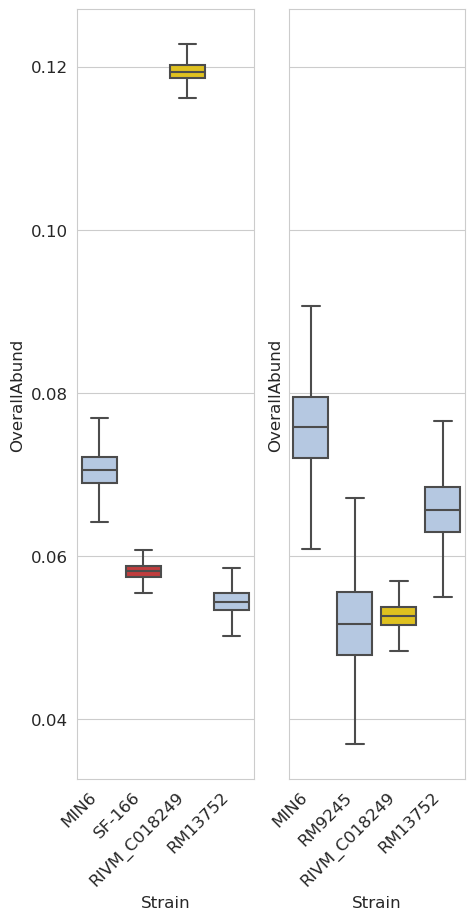

In [323]:
_res = res_cache['UMB18']['plate'][0][1]
_df = _res.annot_df_with_lower_bound(0.05, Taxon('Escherichia', 'coli'))
display(_df)


overall_relabund = _res.overall_ra()
filt_relabund = _res.filt_ra()
df_entries = []
for s_idx in pd.unique(_df['StrainIdx']):
    strain = _res.display_strains[s_idx]
    ra_samples = overall_relabund[0, :, s_idx]
    filt_ra_samples = filt_relabund[0, :, s_idx]
    for i, (abund, filt_abund) in enumerate(zip(ra_samples, filt_ra_samples)):
        df_entries.append({
            'Strain': strain.name,
            'SampleIdx': i,
            'OverallAbund': abund,
            'FilterAbund': filt_abund
        })
culture_df1 = pd.DataFrame(df_entries)
del df_entries






_res = res_cache['UMB18']['plate'][1][1]
_df = _res.annot_df_with_lower_bound(0.05, Taxon('Escherichia', 'coli'))
display(_df)

overall_relabund = _res.overall_ra()
filt_relabund = _res.filt_ra()
df_entries = []
for s_idx in pd.unique(_df['StrainIdx']):
    strain = _res.display_strains[s_idx]
    ra_samples = overall_relabund[0, :, s_idx]
    filt_ra_samples = filt_relabund[0, :, s_idx]
    for i, (abund, filt_abund) in enumerate(zip(ra_samples, filt_ra_samples)):
        df_entries.append({
            'Strain': strain.name,
            'SampleIdx': i,
            'OverallAbund': abund,
            'FilterAbund': filt_abund
        })
culture_df2 = pd.DataFrame(df_entries)
del df_entries


fig, ax = plt.subplots(1, 2, figsize=(5, 10), sharey=True)

sb.boxplot(
    culture_df1,
    x='Strain',
    y='OverallAbund',
    ax=ax[0],
    palette={s.name: phylo_colors[s.phylogroup] for s in db.all_strains()},
    showfliers=False
)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha="right")

sb.boxplot(
    culture_df2,
    x='Strain',
    y='OverallAbund',
    ax=ax[1],
    palette={s.name: phylo_colors[s.phylogroup] for s in db.all_strains()},
    showfliers=False
)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha="right")